# IMPORT

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, GRUCell
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score,average_precision_score

import random

import bisect 

import gc
import copy

from itertools import permutations

import pandas as pd

from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T
from torch_geometric.transforms import SVDFeatureReduction
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit,NormalizeFeatures,Constant,OneHotDegree
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv,SAGEConv,GATv2Conv, GINConv, Linear
from scipy.stats import entropy

import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import copy
import itertools
import json

# LOAD DATASET

In [2]:
from steemitdata import get_steemit_dataset

In [3]:
#Snapshots with constant encoder as node features
#Snapshots with textual features as node features

snapshots_c = get_steemit_dataset(preprocess='constant')
snapshots_t = get_steemit_dataset(preprocess='text')

In [4]:
for i in range(len(snapshots_t)):
    torch.save(snapshots_t[i].x, f'steemit-t3gnn-data/{i}_x.pt')
    torch.save(snapshots_t[i].edge_index, f'steemit-t3gnn-data/{i}_edge_index.pt')

In [5]:
#Snapshots with random features as node features
snapshots_ts = get_steemit_dataset(preprocess='constant')
for snap in snapshots_ts:
    snap.x = torch.randn(snap.num_nodes, 384)

# LOAD MODEL

In [6]:
from newt3gnn import T3GConvGRU, T3EvolveGCNH, T3EvolveGCNO, T3GNN

In [7]:
def roland_test(model, test_data, data, isnap, device='cpu'):
    model.eval()

    test_data = test_data.to(device)

    h, _ = model(test_data.x, test_data.edge_index, edge_label_index = test_data.edge_label_index, isnap=isnap)
    
    pred_cont_link = torch.sigmoid(h).cpu().detach().numpy()
    
    label_link = test_data.edge_label.cpu().detach().numpy()
      
    avgpr_score_link = average_precision_score(label_link, pred_cont_link)
    
    return avgpr_score_link

In [8]:
def ev_test(model, test_data, data, device='cpu'): 
    model.eval()
    test_data = test_data.to(device)
    h = model(test_data.x, test_data.edge_index, test_data.edge_label_index)
    pred_cont = torch.sigmoid(h).cpu().detach().numpy()
    label = test_data.edge_label.cpu().detach().numpy()
    avgpr_score = average_precision_score(label, pred_cont)
    return avgpr_score

In [9]:
def gcgru_test(model, test_data, data, device='cpu'):
    model.eval()
    test_data = test_data.to(device)
    h, _ = model(test_data.x, test_data.edge_index, test_data.edge_label_index)
    pred_cont = torch.sigmoid(h).cpu().detach().numpy()
    label = test_data.edge_label.cpu().detach().numpy()
    avgpr_score = average_precision_score(label, pred_cont)
    return avgpr_score

In [10]:
from sklearn.metrics import *

def roland_train_single_snapshot(model, data, train_data, val_data, test_data, isnap,\
                          last_embeddings, optimizer, device='cpu', num_epochs=50, verbose=False):
    
    avgpr_val_max = 0
    best_model = model
    train_data = train_data.to(device)
    best_epoch = -1
    best_current_embeddings = []
    
    avgpr_trains = []
    #avgpr_vals = []
    avgpr_tests = []
    
    tol = 1
    
    for epoch in range(num_epochs):
        model.train()
        ## Note
        ## 1. Zero grad the optimizer
        ## 2. Compute loss and backpropagate
        ## 3. Update the model parameters
        optimizer.zero_grad()

        pred,\
        current_embeddings =\
            model(train_data.x, train_data.edge_index, edge_label_index = train_data.edge_label_index,\
                  isnap=isnap, previous_embeddings=last_embeddings)
        
        loss = model.loss(pred, train_data.edge_label.type_as(pred)) #loss to fine tune on current snapshot

        loss.backward(retain_graph=True)  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        ##########################################

        log = 'Epoch: {:03d}\n AVGPR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n MRR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n F1-Score Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n Loss: {}'
        avgpr_score_val  = roland_test(model, val_data, data, isnap, device)
        
        #avgpr_trains.append(avgpr_score_train)
        #avgpr_vals.append(avgpr_score_val)
        #avgpr_tests.append(avgpr_score_test)
        
        #mrr_trains.append(mrr_train)
        #mrr_vals.append(mrr_val)
        #mrr_tests.append(mrr_test)
        
        if avgpr_val_max-tol <= avgpr_score_val:
            avgpr_val_max = avgpr_score_val
            best_epoch = epoch
            best_current_embeddings = current_embeddings
            best_model = model
        else:
            break
        
        
    #avgpr_score_train = roland_test(model, train_data, data, isnap, device)
    avgpr_score_test = roland_test(model, test_data, data, isnap, device)
            
    if verbose:
        print(f'Best Epoch: {best_epoch}')
    #print(f'Best Epoch: {best_epoch}')
    
    return best_model, optimizer, avgpr_score_test, best_current_embeddings

In [11]:
def gcgru_train_single_snapshot(model, data, train_data, val_data, test_data,\
                          optimizer, H=None, device='cpu', num_epochs=50, verbose=False):
    
    mrr_val_max = 0
    avgpr_val_max = 0
    best_model = model
    train_data = train_data.to(device)
    best_epoch = -1
    
    tol = 5e-2
    
    best_H = None
    
    for epoch in range(num_epochs):
        model.train()
        ## Note
        ## 1. Zero grad the optimizer
        ## 2. Compute loss and backpropagate
        ## 3. Update the model parameters
        optimizer.zero_grad()
        
        #H = None
            
        pred, H = model(train_data.x, train_data.edge_index, train_data.edge_label_index, H)
        
        loss = model.loss(pred, train_data.edge_label.type_as(pred)) #loss to fine tune on current snapshot

        loss.backward(retain_graph=True)  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        ##########################################

        log = 'Epoch: {:03d}\n AVGPR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n MRR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n F1-Score Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n Loss: {}'
        avgpr_score_val = gcgru_test(model, val_data, data, device)
        
        """
        if mrr_val_max-tol < mrr_val:
            mrr_val_max = mrr_val
            best_epoch = epoch
            best_current_embeddings = current_embeddings
            best_model = copy.deepcopy(model)
        else:
            break
        
        #print(f'Epoch: {epoch} done')
            
        """
        if avgpr_val_max-tol <= avgpr_score_val:
            avgpr_val_max = avgpr_score_val
            best_H = H.clone()
            best_epoch = epoch
            best_model = model
        else:
            break
        
    avgpr_score_test = gcgru_test(model, test_data, data, device)
            
    if verbose:
        print(f'Best Epoch: {best_epoch}')
    #print(f'Best Epoch: {best_epoch}')
    
    return best_model, avgpr_score_test, best_H, optimizer

In [12]:
def ev_train_single_snapshot(model, data, train_data, val_data, test_data,\
                          optimizer, device='cpu', num_epochs=50, verbose=False):
    
    mrr_val_max = 0
    avgpr_val_max = 0
    best_model = model
    train_data = train_data.to(device)
    best_epoch = -1
    
    tol = 5e-2
    
    for epoch in range(num_epochs):
        model.train()
        ## Note
        ## 1. Zero grad the optimizer
        ## 2. Compute loss and backpropagate
        ## 3. Update the model parameters
        optimizer.zero_grad()
            
        pred = model(train_data.x, train_data.edge_index, train_data.edge_label_index)
        
        loss = model.loss(pred, train_data.edge_label.type_as(pred)) #loss to fine tune on current snapshot

        loss.backward(retain_graph=True)  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        ##########################################

        log = 'Epoch: {:03d}\n AVGPR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n MRR Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n F1-Score Train: {:.4f}, Val: {:.4f}, Test: {:.4f}\n Loss: {}'
        avgpr_score_val = ev_test(model, val_data, data, device)
        
        """
        if mrr_val_max-tol < mrr_val:
            mrr_val_max = mrr_val
            besst_epoch = epoch
            best_current_embeddings = current_embeddings
            best_model = copy.deepcopy(model)
        else:
            break
        
        #print(f'Epoch: {epoch} done')
            
        """
        if avgpr_val_max-tol <= avgpr_score_val:
            avgpr_val_max = avgpr_score_val
            best_epoch = epoch
            best_model = model
        else:
            break
        
    avgpr_score_test = ev_test(model, test_data, data, device)
            
    if verbose:
        print(f'Best Epoch: {best_epoch}')
    #print(f'Best Epoch: {best_epoch}')
    
    return best_model, avgpr_score_test, optimizer

In [13]:
def train_models(snapshots, hidden_conv1, hidden_conv2, update='gru', device='cpu'):
    """
        Train and evaluate all the baselines in the live update setting
    """
    num_snap = len(snapshots)
    input_channels = snapshots[0].x.size(1)
    num_nodes = snapshots[0].x.size(0)
    last_embeddings = [torch.Tensor([[0 for i in range(hidden_conv1)] for j in range(num_nodes)]),\
                                    torch.Tensor([[0 for i in range(hidden_conv2)] for j in range(num_nodes)])]
    
    #TODO: rifare per ogni modello
    ro_avgpr_test_singles = []
    gcgru_avgpr_test_singles = []
    evo_avgpr_test_singles = []
    evh_avgpr_test_singles = []
    
    roland = T3GNN(input_channels, 2, hidden_conv1, dropout=0.3, update=update)
    rolopt = torch.optim.Adam(params=roland.parameters(), lr=0.01, weight_decay = 5e-3)
    roland.reset_parameters()
    
    gcgru = T3GConvGRU(input_channels, hidden_conv2)
    gcgruopt = torch.optim.Adam(params=gcgru.parameters(), lr=0.01, weight_decay = 5e-3)
    gcgru.reset_parameters()
    H = None
    
    evh = T3EvolveGCNH(num_nodes, input_channels)
    evhopt = torch.optim.Adam(params=evh.parameters(), lr=0.01, weight_decay = 5e-3)
    evh.reset_parameters()
    
    evo = T3EvolveGCNO(input_channels)
    evopt = torch.optim.Adam(params=evo.parameters(), lr=0.01, weight_decay = 5e-3)
    evo.reset_parameters()
    
    for i in range(num_snap-1):
        #CREATE TRAIN + VAL + TEST SET FOR THE CURRENT SNAP
        snapshot = copy.deepcopy(snapshots[i])
        num_current_edges = len(snapshot.edge_index[0])
        transform = RandomLinkSplit(num_val=0.0,num_test=0.25)
        train_data, _, val_data = transform(snapshot)
        test_data = copy.deepcopy(snapshots[i+1])
        
        #NEGATIVE SET: EDGES CLOSED IN THE PAST BUT NON IN THE CURRENT TEST SET
        past_edges = set(zip([int(e) for e in snapshot.edge_index[0]],\
                             [int(e) for e in snapshot.edge_index[1]]))
        current_edges = set(zip([int(e) for e in test_data.edge_index[0]],\
                             [int(e) for e in test_data.edge_index[1]]))
        
        negative_edges = list(past_edges.difference(current_edges))[:test_data.edge_index.size(1)]
        future_neg_edge_index = torch.Tensor([[a[0] for a in negative_edges],\
                                                 [a[1] for a in negative_edges]]).long()
        
        num_pos_edge = test_data.edge_index.size(1)
        num_neg_edge = future_neg_edge_index.size(1)
        test_data.edge_label = torch.Tensor(np.array([1 for i in range(num_pos_edge)] + [0 for i in range(num_neg_edge)]))
        test_data.edge_label_index = torch.cat([test_data.edge_index, future_neg_edge_index], dim=-1)
        
        #TRAIN AND TEST THE MODELS FOR THE CURRENT SNAP
        roland, rolopt, ro_avgpr_test, last_embeddings =\
            roland_train_single_snapshot(roland, snapshot, train_data, val_data, test_data, i,\
                                  last_embeddings, rolopt)
        
        gcgru, gcgru_avgpr_test, H, gcgruopt =\
            gcgru_train_single_snapshot(gcgru, snapshot, train_data, val_data, test_data, gcgruopt, H)
        
        evo, evo_avgpr_test, evopt =\
            ev_train_single_snapshot(evo, snapshot, train_data, val_data, test_data, evopt)
        
        evh, evh_avgpr_test, evhopt =\
            ev_train_single_snapshot(evh, snapshot, train_data, val_data, test_data, evhopt)
        
        
        #SAVE AND DISPLAY EVALUATION
        print(f'Snapshot: {i}\n\tT3GNN AVGPR Test: {ro_avgpr_test}')
        print(f'\tGCGRU AVGPR Test: {gcgru_avgpr_test}')
        print(f'\tEvolveGCN-O AVGPR Test: {evo_avgpr_test}')
        print(f'\tEvolveGCN-H AVGPR Test: {evh_avgpr_test}')
        
        ro_avgpr_test_singles.append(ro_avgpr_test)
        gcgru_avgpr_test_singles.append(gcgru_avgpr_test)
        evo_avgpr_test_singles.append(evo_avgpr_test)
        evh_avgpr_test_singles.append(evh_avgpr_test)
        
    ro_avgpr_test_all = sum(ro_avgpr_test_singles)/len(ro_avgpr_test_singles)
    gcgru_avgpr_test_all = sum(gcgru_avgpr_test_singles)/len(gcgru_avgpr_test_singles)
    evo_avgpr_test_all = sum(evo_avgpr_test_singles)/len(evo_avgpr_test_singles)
    evh_avgpr_test_all = sum(evh_avgpr_test_singles)/len(evh_avgpr_test_singles)
    
    print(f'T3GNN AVGPR over time: Test: {ro_avgpr_test_all}')
    print(f'GCGRU AVGPR over time: Test: {gcgru_avgpr_test_all}')
    print(f'EvolveGCN-O AVGPR over time: Test: {evo_avgpr_test_all}')
    print(f'EvolveGCN-H AVGPR over time: Test: {evh_avgpr_test_all}')
    
    return ro_avgpr_test_singles, gcgru_avgpr_test_singles, evo_avgpr_test_singles, evh_avgpr_test_singles

In [14]:
def train_roland(snapshots, hidden_conv1, hidden_conv2, update='gru', device='cpu'):
    """
        Train and evaluate T3GNN with historical negative edges in the live update setting
    """
    num_snap = len(snapshots)
    input_channels = snapshots[0].x.size(1)
    num_nodes = snapshots[0].x.size(0)
    last_embeddings = [torch.Tensor([[0 for i in range(hidden_conv1)] for j in range(num_nodes)]),\
                                    torch.Tensor([[0 for i in range(hidden_conv2)] for j in range(num_nodes)])]
 
    avgpr_test_singles = []
    
    roland = T3GNN(input_channels, 2, hidden_conv1, dropout=0.3, update=update)
    rolopt = torch.optim.Adam(params=roland.parameters(), lr=0.01, weight_decay = 5e-3)
    roland.reset_parameters()
    
    for i in range(num_snap-1):
        #CREATE TRAIN + VAL + TEST SET FOR THE CURRENT SNAP
        snapshot = copy.deepcopy(snapshots[i])
        num_current_edges = len(snapshot.edge_index[0])
        transform = RandomLinkSplit(num_val=0.0,num_test=0.25)
        train_data, _, val_data = transform(snapshot)
        test_data = copy.deepcopy(snapshots[i+1])
        
        #NEGATIVE SET: EDGES CLOSED IN THE PAST BUT NON IN THE CURRENT TEST SET
        past_edges = set(zip([int(e) for e in snapshot.edge_index[0]],\
                             [int(e) for e in snapshot.edge_index[1]]))
        current_edges = set(zip([int(e) for e in test_data.edge_index[0]],\
                             [int(e) for e in test_data.edge_index[1]]))
        
        negative_edges = list(past_edges.difference(current_edges))[:test_data.edge_index.size(1)]
        future_neg_edge_index = torch.Tensor([[a[0] for a in negative_edges],\
                                                 [a[1] for a in negative_edges]]).long()
        
        num_pos_edge = test_data.edge_index.size(1)
        num_neg_edge = future_neg_edge_index.size(1)
        test_data.edge_label = torch.Tensor(np.array([1 for i in range(num_pos_edge)] + [0 for i in range(num_neg_edge)]))
        test_data.edge_label_index = torch.cat([test_data.edge_index, future_neg_edge_index], dim=-1)
        
        #TRAIN AND TEST THE MODEL FOR THE CURRENT SNAP
        roland, rolopt, avgpr_test, last_embeddings =\
            roland_train_single_snapshot(roland, snapshot, train_data, val_data, test_data, i,\
                                  last_embeddings, rolopt)
        
        
        #SAVE AND DISPLAY EVALUATION
        print(f'Snapshot: {i}\n\tT3GNN AVGPR Test: {avgpr_test}')
        avgpr_test_singles.append(avgpr_test)
        
    avgpr_test_all = sum(avgpr_test_singles)/len(avgpr_test_singles)
    
    print(f'T3GNN AVGPR over time Test: {avgpr_test_all}')
    
    return avgpr_test_singles

In [15]:
def train_roland_random(snapshots, hidden_conv1, hidden_conv2, update='gru', device='cpu'):
    """
        Train T3GNN with random negative sampling
    """
    num_snap = len(snapshots)
    input_channels = snapshots[0].x.size(1)
    num_nodes = snapshots[0].x.size(0)
    last_embeddings = [torch.Tensor([[0 for i in range(hidden_conv1)] for j in range(num_nodes)]),\
                                    torch.Tensor([[0 for i in range(hidden_conv2)] for j in range(num_nodes)])]
 
    avgpr_test_singles = []
    
    roland = T3GNN(input_channels, 2, hidden_conv1, dropout=0.3, update=update)
    rolopt = torch.optim.Adam(params=roland.parameters(), lr=0.01, weight_decay = 5e-3)
    roland.reset_parameters()
    
    for i in range(num_snap-1):
        #CREATE TRAIN + VAL + TEST SET FOR THE CURRENT SNAP
        snapshot = copy.deepcopy(snapshots[i])
        num_current_edges = len(snapshot.edge_index[0])
        transform = RandomLinkSplit(num_val=0.0,num_test=0.25)
        train_data, _, val_data = transform(snapshot)
        test_data = copy.deepcopy(snapshots[i+1])
        
        future_neg_edge_index = negative_sampling(
            edge_index=test_data.edge_index, #positive edges
            num_nodes=test_data.num_nodes, # number of nodes
            num_neg_samples=test_data.edge_index.size(1)) # number of neg_sample equal to number of pos_edges
        #edge index ok, edge_label concat, edge_label_index concat
        num_pos_edge = test_data.edge_index.size(1)
        test_data.edge_label = torch.Tensor(np.array([1 for i in range(num_pos_edge)] + [0 for i in range(num_pos_edge)]))
        test_data.edge_label_index = torch.cat([test_data.edge_index, future_neg_edge_index], dim=-1)
        
        #TRAIN AND TEST THE MODEL FOR THE CURRENT SNAP
        roland, rolopt, avgpr_test, last_embeddings =\
            roland_train_single_snapshot(roland, snapshot, train_data, val_data, test_data, i,\
                                  last_embeddings, rolopt)
        
        
        #SAVE AND DISPLAY EVALUATION
        print(f'Snapshot: {i}\n\tT3GNN random sampling AVGPR Test: {avgpr_test}')
        avgpr_test_singles.append(avgpr_test)
        
    avgpr_test_all = sum(avgpr_test_singles)/len(avgpr_test_singles)
    
    print(f'T3GNN AVGPR over time Test: {avgpr_test_all}')
    
    return avgpr_test_singles

## Experiments

In [16]:
import random
device = torch.device('cuda')
torch.manual_seed(41)
torch.cuda.manual_seed_all(41)
np.random.seed(41)
random.seed(41)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

In [17]:
hidden_conv1 = 64
hidden_conv2 = 32

### Train on the link prediction task using sentence embedding and network structure

In [18]:
ro_avgpr, gcgru_avgpr, evo_avgpr, evh_avgpr = train_models(snapshots_t, hidden_conv1, hidden_conv2, update='mlp')

Snapshot: 0
	T3GNN AVGPR Test: 0.825788745067392
	GCGRU AVGPR Test: 0.7862122401951436
	EvolveGCN-O AVGPR Test: 0.8146681377917695
	EvolveGCN-H AVGPR Test: 0.8152436299002714
Snapshot: 1
	T3GNN AVGPR Test: 0.7864263027747045
	GCGRU AVGPR Test: 0.5712967896591414
	EvolveGCN-O AVGPR Test: 0.7316277164688902
	EvolveGCN-H AVGPR Test: 0.7353740816791263
Snapshot: 2
	T3GNN AVGPR Test: 0.6581120701606737
	GCGRU AVGPR Test: 0.625093442585807
	EvolveGCN-O AVGPR Test: 0.6657813347680592
	EvolveGCN-H AVGPR Test: 0.6647526115237742
Snapshot: 3
	T3GNN AVGPR Test: 0.8769727028681255
	GCGRU AVGPR Test: 0.7515756108080062
	EvolveGCN-O AVGPR Test: 0.7489617550129761
	EvolveGCN-H AVGPR Test: 0.7461889763196548
Snapshot: 4
	T3GNN AVGPR Test: 0.8385418453917273
	GCGRU AVGPR Test: 0.6546909009784708
	EvolveGCN-O AVGPR Test: 0.7534197537146619
	EvolveGCN-H AVGPR Test: 0.7567885487860144
Snapshot: 5
	T3GNN AVGPR Test: 0.8500335663403047
	GCGRU AVGPR Test: 0.6229775146311542
	EvolveGCN-O AVGPR Test: 0.7655994

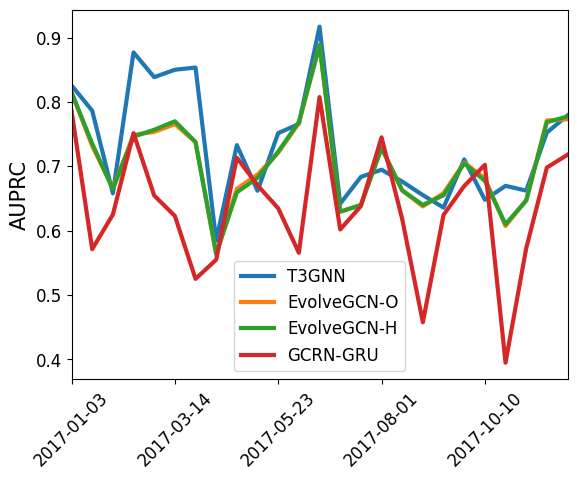

In [19]:
x = range(0,25)
x_ticks_labels = ['2017-01-03','2017-03-14', '2017-05-23', '2017-08-01', '2017-10-10']
ticks = [0, 5, 10, 15, 20]
plt.plot(x, ro_avgpr, label='T3GNN', linewidth=3)
plt.plot(x, evo_avgpr, label='EvolveGCN-O', linewidth=3)
plt.plot(x, evh_avgpr, label='EvolveGCN-H', linewidth=3)
plt.plot(x, gcgru_avgpr, label='GCRN-GRU', linewidth=3)
#plt.xlabel('2-Week', fontsize=15)
plt.xlim((0,24))
plt.ylabel('AUPRC', fontsize=15)
plt.xticks(fontsize=12, ticks= ticks, labels=x_ticks_labels, rotation=45)
plt.yticks(fontsize=12)
#plt.title('Link prediction performance over time', fontsize=15)
plt.legend(fontsize=12)
#plt.savefig('results/t3gnn-baselines.pdf',bbox_inches='tight')
plt.show()

In [20]:
"""
# open file in write mode
def write_results(fname, listname):
    with open(f'results/run2/{fname}.txt', 'w') as fp:
        for item in listname:
            # write each item on a new line
            fp.write("%s\n" % item)
"""

'\n# open file in write mode\ndef write_results(fname, listname):\n    with open(f\'results/run2/{fname}.txt\', \'w\') as fp:\n        for item in listname:\n            # write each item on a new line\n            fp.write("%s\n" % item)\n'

In [21]:
#write_results('ro',ro_avgpr)
#write_results('gcgru',gcgru_avgpr)
#write_results('evo', evo_avgpr)
#write_results('evh', evh_avgpr)

### Random Sampling

In [22]:
ro_randomsample_avgpr = train_roland_random(snapshots_t, hidden_conv1, hidden_conv2, update='mlp') #random-negative-sampling

Snapshot: 0
	T3GNN random sampling AVGPR Test: 0.88682511529329
Snapshot: 1
	T3GNN random sampling AVGPR Test: 0.9275781792035767
Snapshot: 2
	T3GNN random sampling AVGPR Test: 0.8954837841116251
Snapshot: 3
	T3GNN random sampling AVGPR Test: 0.9292362759735662
Snapshot: 4
	T3GNN random sampling AVGPR Test: 0.9045370539822746
Snapshot: 5
	T3GNN random sampling AVGPR Test: 0.9105597054010727
Snapshot: 6
	T3GNN random sampling AVGPR Test: 0.9282670732358483
Snapshot: 7
	T3GNN random sampling AVGPR Test: 0.8908909338441745
Snapshot: 8
	T3GNN random sampling AVGPR Test: 0.9331652170234614
Snapshot: 9
	T3GNN random sampling AVGPR Test: 0.8933199293681431
Snapshot: 10
	T3GNN random sampling AVGPR Test: 0.9065681870841183
Snapshot: 11
	T3GNN random sampling AVGPR Test: 0.9188736312251707
Snapshot: 12
	T3GNN random sampling AVGPR Test: 0.9333803092128988
Snapshot: 13
	T3GNN random sampling AVGPR Test: 0.9191421418654313
Snapshot: 14
	T3GNN random sampling AVGPR Test: 0.910941326462082
Snapshot

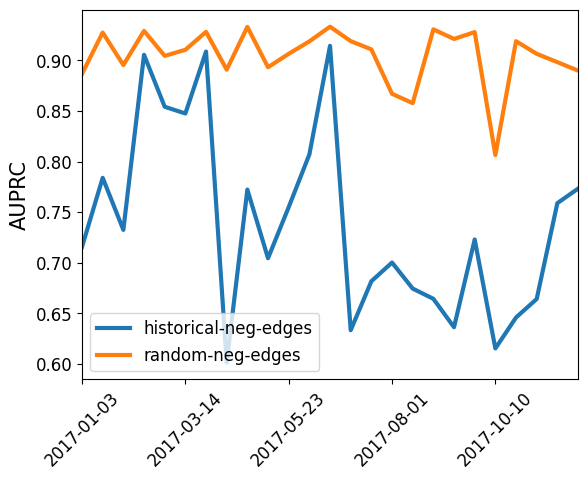

In [23]:
x = range(0,25)
x_ticks_labels = ['2017-01-03','2017-03-14', '2017-05-23', '2017-08-01', '2017-10-10']
ticks = [0, 5, 10, 15, 20]
plt.plot(x, ro_avgpr, label='historical-neg-edges', linewidth=3)
plt.plot(x, ro_randomsample_avgpr, label='random-neg-edges', linewidth=3)
#plt.xlabel('2-Week', fontsize=15)
plt.xlim((0,24))
plt.ylabel('AUPRC', fontsize=15)
plt.xticks(fontsize=12, labels=x_ticks_labels, ticks=ticks, rotation=45)
plt.yticks(fontsize=12)
#plt.title('Link prediction performance over time', fontsize=15)
plt.legend(fontsize=12)
#plt.savefig('results/t3gnn-negative-sampling.pdf',bbox_inches='tight')
plt.show()

### Random Features

In [24]:
ro_constant_avgpr = train_roland(snapshots_c, hidden_conv1, hidden_conv2, update='mlp') #no-features
ro_randomf_avgpr = train_roland(snapshots_ts, hidden_conv1, hidden_conv2, update='mlp') #random_features

Snapshot: 0
	T3GNN AVGPR Test: 0.7234342144933512
Snapshot: 1
	T3GNN AVGPR Test: 0.49772395609313125
Snapshot: 2
	T3GNN AVGPR Test: 0.6153314890161251
Snapshot: 3
	T3GNN AVGPR Test: 0.7369443447727414
Snapshot: 4
	T3GNN AVGPR Test: 0.8323126736492965
Snapshot: 5
	T3GNN AVGPR Test: 0.8911416244738729
Snapshot: 6
	T3GNN AVGPR Test: 0.8681284621509449
Snapshot: 7
	T3GNN AVGPR Test: 0.7050857831278953
Snapshot: 8
	T3GNN AVGPR Test: 0.7328525908012696
Snapshot: 9
	T3GNN AVGPR Test: 0.6897421182769246
Snapshot: 10
	T3GNN AVGPR Test: 0.7350104293175287
Snapshot: 11
	T3GNN AVGPR Test: 0.8092514344426405
Snapshot: 12
	T3GNN AVGPR Test: 0.9209866348432164
Snapshot: 13
	T3GNN AVGPR Test: 0.646343395921907
Snapshot: 14
	T3GNN AVGPR Test: 0.6883778268308475
Snapshot: 15
	T3GNN AVGPR Test: 0.7021075903812503
Snapshot: 16
	T3GNN AVGPR Test: 0.6913022719084212
Snapshot: 17
	T3GNN AVGPR Test: 0.6388227546297873
Snapshot: 18
	T3GNN AVGPR Test: 0.6547081890596614
Snapshot: 19
	T3GNN AVGPR Test: 0.7182936

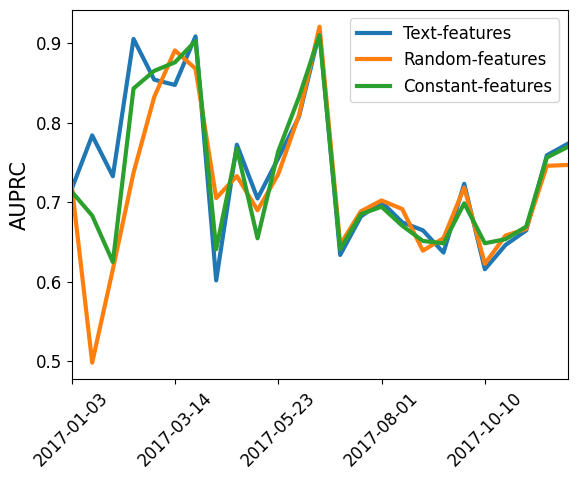

In [25]:
x = range(0,25)
x_ticks_labels = ['2017-01-03','2017-03-14', '2017-05-23', '2017-08-01', '2017-10-10']
ticks = [0, 5, 10, 15, 20]
plt.plot(x, ro_avgpr, label='Text-features', linewidth=3)
plt.plot(x, ro_constant_avgpr, label='Random-features', linewidth=3)
plt.plot(x, ro_randomf_avgpr, label='Constant-features', linewidth=3)
#plt.xlabel('2-Week', fontsize=15)
plt.xlim((0,24))
plt.ylabel('AUPRC', fontsize=15)
plt.xticks(fontsize=12, labels=x_ticks_labels, ticks=ticks, rotation=45)
plt.yticks(fontsize=12)
#plt.title('Link prediction performance over time', fontsize=15)
plt.legend(fontsize=12)
#plt.savefig('results/t3gnn-random-features.pdf',bbox_inches='tight')
plt.show()

#### Dataset stat plot

In [26]:
comment_op = [
    191712,
    174692,
    156561,
    141733,
    130279,
    181194,
    135637,
    133169,
    174483,
    289970,
    341374,
    448947,
    552799,
    411647,
    337296,
    298362,
    269092,
    270818,
    243382,
    235857,
    190407,
    199524,
    222980,
    217708,
    234757
]

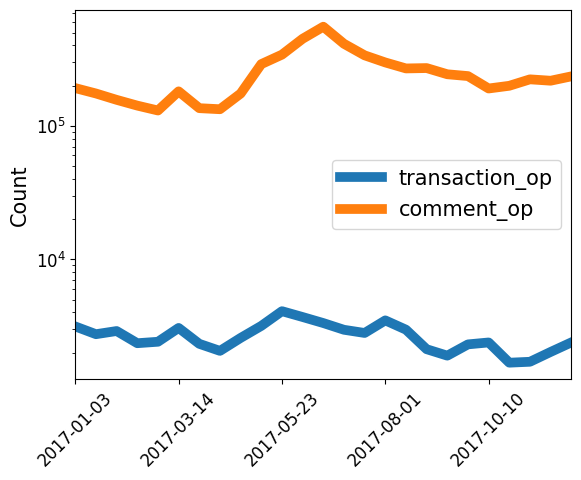

In [27]:
plt.plot(range(0,25),[e.edge_index.size(1) for e in snapshots_c[1:]], label='transaction_op', linewidth=7)
plt.plot(range(0,25),comment_op, label='comment_op', linewidth=7)
x_ticks_labels = ['2017-01-03','2017-03-14', '2017-05-23', '2017-08-01', '2017-10-10']
ticks = [0, 5, 10, 15, 20]
plt.yscale('log')
#plt.xlabel('2-Week',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(fontsize=12, labels=x_ticks_labels, ticks=ticks, rotation=45)
plt.yticks(fontsize=12)
plt.xlim(0,24)
plt.legend(fontsize=15)
#plt.title('Number of operations per 2-week')
#plt.savefig('results/operations-wide20-notitle.pdf',bbox_inches='tight')
plt.show()